# Transfer Learning with TensorFlow: Fine-Tuning

In [1]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, walk_through_dir

## Get data

In [2]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [3]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [4]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [5]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [6]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [7]:
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[ 88.31633     65.31633     49.316326  ]
   [ 87.2602      63.188774    46.260204  ]
   [ 88.57653     62.357143    44.790817  ]
   ...
   [ 13.826533    12.964274    10.964274  ]
   [ 12.341782     8.341782     5.3417816 ]
   [ 12.831804     8.54609      4.1889477 ]]

  [[ 85.42347     59.352043    46.4949    ]
   [ 93.13265     65.13265     51.27551   ]
   [ 92.42857     64.88776     48.27041   ]
   ...
   [ 11.892715    10.066247     6.734554  ]
   [ 10.923469     6.9234686    3.9234686 ]
   [ 15.454224    12.454224     7.4542236 ]]

  [[ 73.44388     46.44388     37.01531   ]
   [ 91.40306     64.188774    52.97449   ]
   [ 90.85715     62.47449     49.617348  ]
   ...
   [ 16.719336    12.505073     9.505073  ]
   [ 10.88267      7.6683846    3.0969565 ]
   [ 16.515398    13.515398     8.515398  ]]

  ...

  [[ 38.617558    44.046143    37.617558  ]
   [ 23.964315    28.964315    22.750021  ]
   [ 24.61734     27.122461    21.954088  ]
   ...
   [  2.           2.   

## Model 0: Building a transfer learning model using the Keras Functional API

In [8]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
# 2. Freeze the model
base_model.trainable = False

# 3. Create inputs into the model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool of the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history_0 = model_0.fit(
    train_data_10_percent,
    steps_per_epoch=len(train_data_10_percent),
    epochs=20,
    verbose=True,
    callbacks=[
        create_tensorboard_callback("05_tensorboard_logs", "10_percent_feature_extraction")
    ],
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data))
)


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: 05_tensorboard_logs/10_percent_feature_extraction/20210813-112953


C:\ProgramData\Anaconda3\envs\general_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/20
24/24 [==============================] - 15s 235ms/step - loss: 1.9243 - accuracy: 0.3747 - val_loss: 1.3480 - val_accuracy: 0.6908
Epoch 2/20
24/24 [==============================] - 3s 117ms/step - loss: 1.1593 - accuracy: 0.7453 - val_loss: 0.9352 - val_accuracy: 0.7664
Epoch 3/20
24/24 [==============================] - 3s 118ms/step - loss: 0.8515 - accuracy: 0.8040 - val_loss: 0.7367 - val_accuracy: 0.8405
Epoch 4/20
24/24 [==============================] - 3s 119ms/step - loss: 0.6973 - accuracy: 0.8493 - val_loss: 0.6381 - val_accuracy: 0.8520
Epoch 5/20
24/24 [==============================] - 3s 113ms/step - loss: 0.6006 - accuracy: 0.8613 - val_loss: 0.6035 - val_accuracy: 0.8520
Epoch 6/20
24/24 [==============================] - 3s 119ms/step - loss: 0.5205 - accuracy: 0.8880 - val_loss: 0.5706 - val_accuracy: 0.8586
Epoch 7/20
24/24 [==============================] - 3s 113ms/step - loss: 0.4685 - accuracy: 0.9093 - val_loss: 0.5361 - val_accuracy: 0.8586
Epoch

In [9]:
model_0.evaluate(test_data)

79/79 [==============================] - 5s 63ms/step - loss: 0.4439 - accuracy: 0.8568


[0.4439255893230438, 0.8568000197410583]

In [10]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [11]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [12]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


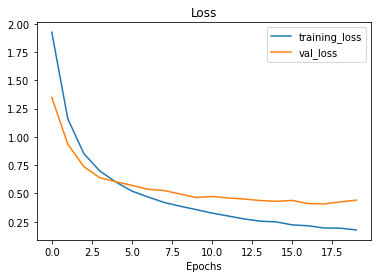

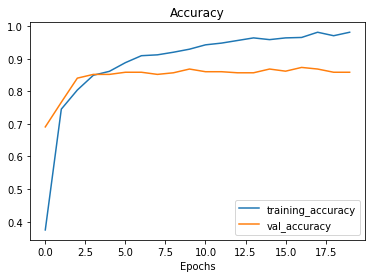

In [13]:
plot_loss_curves(history_0)

# Getting a feature vector from a trained model

Demonstrate the Global Average Pooling 2D layer

Similar shaped tensor (1,4,4,3) and pass it to GlobalAveragePooling2D

In [18]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(global_average_pooled_tensor.shape)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

(1, 3)
2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [19]:
# Replicate the GlobalAveragePooling2D
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [20]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global max pooling 2D layer
global_max_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(global_max_pooled_tensor.shape)
print(f"2D global max pooled random tensor:\n {global_max_pooled_tensor}\n")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

(1, 3)
2D global max pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



# Running a series of transfer learning experiments